In [8]:
import os
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [12]:
# Set input and output directories
input_dir = '/root/juno/time_series_data'  # Time-Series 데이터 폴더 경로
output_dir = '/root/juno/peak_detection_results'  # 결과 저장 경로
os.makedirs(output_dir, exist_ok=True)
output_segments_dir = os.path.join(output_dir, "segments2")
os.makedirs(output_segments_dir, exist_ok=True)


# Initialize results storage
peak_results = []

In [10]:
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_dir, file_name)

        # Load the CSV file
        data = pd.read_csv(file_path)

        # Extract class label and person ID (assuming they are in the first few columns)
        class_label = data['class'].iloc[0]
        person_id = data['person_id'].iloc[0]

        # Iterate over all x, y, z coordinates for selected keypoints
        coordinates = ['y']
        keypoints = ['LEFT_ELBOW']
        
        for coord in coordinates:
            for keypoint in keypoints:
                col_name = f"{keypoint}_{coord}"  # 예: LEFT_ELBOW_y
                if col_name in data.columns:
                    # Extract the time-series data for this keypoint and coordinate
                    time_series = data[col_name].dropna().values

                    # Detect troughs (극소값)
                    troughs, _ = find_peaks(-time_series, distance=1)

                    # Ensure there are enough troughs to create segments
                    if len(troughs) > 1:
                        for i in range(len(troughs) - 1):
                            start = troughs[i]
                            end = troughs[i + 1]
                            print(f'start:{start}')
                            print(f'end={end}')

                            # Extract segment data
                            segment = data.iloc[start:end+1]

                            # Save the segment to a new CSV file
                            segment_file_name = f"{file_name}_{keypoint}_{coord}_segment_{i+1}.csv"
                            segment.to_csv(os.path.join(output_segments_dir, segment_file_name), index=False)

                    # Plot the time series and detected extrema
                    plt.figure(figsize=(10, 6))
                    plt.plot(time_series, label='Time Series')
                    plt.plot(troughs, time_series[troughs], 'bo', label='Detected Troughs')
                    plt.title(f"Trough-to-Trough Segmentation: {keypoint} ({coord}) - {file_name}")
                    plt.xlabel('Time')
                    plt.ylabel(f'{coord.upper()} Value')
                    plt.legend()
                    plt.grid()

                    # Save plot
                    plot_file_name = f"{file_name}_{keypoint}_{coord}_segments.png"
                    plt.savefig(os.path.join(output_dir, plot_file_name))
                    plt.close()

start:4
end=9
start:9
end=13
start:13
end=17
start:17
end=21
start:21
end=25
start:25
end=28
start:2
end=5
start:5
end=7
start:7
end=10
start:10
end=13
start:13
end=16
start:16
end=19
start:19
end=22
start:22
end=25
start:4
end=6
start:6
end=9
start:9
end=12
start:12
end=15
start:15
end=19
start:19
end=22
start:22
end=27
start:27
end=29
start:1
end=4
start:4
end=8
start:8
end=11
start:11
end=15
start:15
end=19
start:19
end=22
start:22
end=26
start:26
end=30
start:4
end=7
start:7
end=10
start:10
end=13
start:13
end=16
start:16
end=19
start:19
end=22
start:22
end=25
start:5
end=7
start:7
end=10
start:10
end=13
start:13
end=16
start:16
end=19
start:19
end=22
start:22
end=28
start:4
end=6
start:6
end=9
start:9
end=12
start:12
end=15
start:15
end=17
start:17
end=20
start:20
end=23
start:23
end=27
start:2
end=5
start:5
end=8
start:8
end=10
start:10
end=13
start:13
end=16
start:16
end=19
start:19
end=21
start:21
end=24
start:24
end=27
start:27
end=29
start:5
end=7
start:7
end=10
start:10
end=

In [14]:
# Define function to merge two reps into one
def merge_reps(data, troughs):
    """
    Merge two consecutive reps into one segment.
    Handles odd-numbered reps by repeating the last segment.

    Parameters:
        data (DataFrame): Original time-series data.
        troughs (list): List of trough indices.

    Returns:
        list of DataFrames: Merged segments.
    """
    merged_segments = []

    # If odd number of troughs, duplicate the last one
    # if len(troughs) % 2 != 0:
    #     troughs.append(troughs[-1])  # Duplicate the last trough

    # Merge two consecutive troughs
    for i in range(0, len(troughs) - 2):  # Step by 2
        start = troughs[i]
        end = troughs[i + 2]  # Merge 1st ~ 3rd, 2nd ~ 4th, etc.
        segment = data.iloc[start:end + 1]
        merged_segments.append(segment)

    return merged_segments

# Main processing
for file_name in os.listdir(input_dir):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_dir, file_name)

        # Load the CSV file
        data = pd.read_csv(file_path)

        # Extract class label and person ID (assuming they are in the first few columns)
        class_label = data['class'].iloc[0]
        person_id = data['person_id'].iloc[0]

        # Iterate over all x, y, z coordinates for selected keypoints
        coordinates = ['y']
        keypoints = ['LEFT_ELBOW']
        
        for coord in coordinates:
            for keypoint in keypoints:
                col_name = f"{keypoint}_{coord}"  # 예: LEFT_ELBOW_y
                if col_name in data.columns:
                    # Extract the time-series data for this keypoint and coordinate
                    time_series = data[col_name].dropna().values

                    # Detect troughs (극소값)
                    troughs, _ = find_peaks(-time_series, distance=1)

                    # Ensure there are enough troughs
                    if len(troughs) > 1:
                        # Merge reps
                        merged_segments = merge_reps(data, troughs)

                        # Save each merged segment
                        for idx, segment in enumerate(merged_segments):
                            segment_file_name = f"{file_name}_{keypoint}_{coord}_merged_segment_{idx + 1}.csv"
                            segment.to_csv(os.path.join(output_segments_dir, segment_file_name), index=False)

                    # Plot the time series and detected extrema
                    plt.figure(figsize=(10, 6))
                    plt.plot(time_series, label='Time Series')
                    plt.plot(troughs, time_series[troughs], 'bo', label='Detected Troughs')
                    plt.title(f"Merged Segments: {keypoint} ({coord}) - {file_name}")
                    plt.xlabel('Time')
                    plt.ylabel(f'{coord.upper()} Value')
                    plt.legend()
                    plt.grid()

                    # Save plot
                    plot_file_name = f"{file_name}_{keypoint}_{coord}_merged_segments.png"
                    plt.savefig(os.path.join(output_dir, plot_file_name))
                    plt.close()


KeyboardInterrupt: 

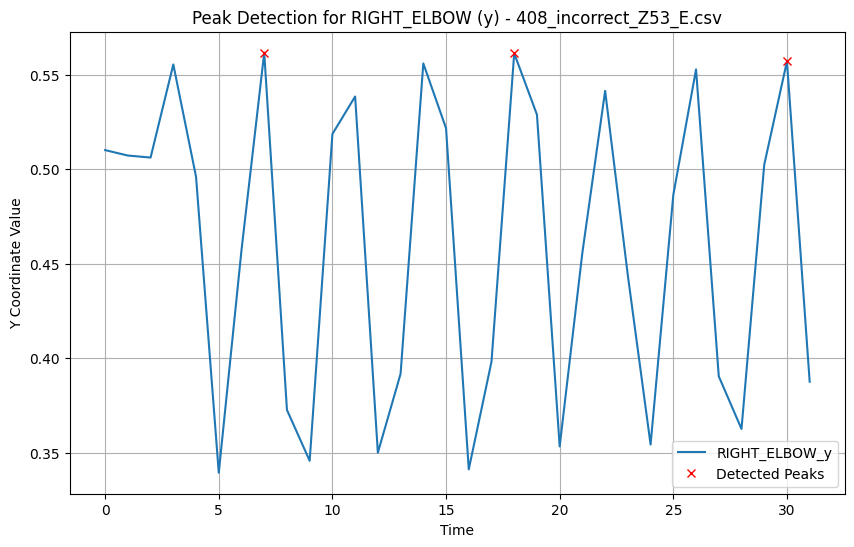

In [6]:
#    # Process each CSV file in the input directory
#    for file_name in os.listdir(input_dir):
#        if file_name.endswith('.csv'):
#            file_path = os.path.join(input_dir, file_name)
#    
#            # Load the CSV file
#            data = pd.read_csv(file_path)
#    
#            # Extract class label and person ID (assuming they are in the first few columns)
#            class_label = data['class'].iloc[0]
#            person_id = data['person_id'].iloc[0]
#    
#            # y 좌표 데이터 추출 (모든 선택된 키포인트)
#            keypoints = ['LEFT_SHOULDER', 'RIGHT_SHOULDER', 'LEFT_ELBOW', 'RIGHT_ELBOW',
#                         'LEFT_WRIST', 'RIGHT_WRIST', 'LEFT_PINKY', 'RIGHT_PINKY',
#                         'LEFT_INDEX', 'RIGHT_INDEX', 'LEFT_THUMB', 'RIGHT_THUMB']
#    
#            for keypoint in keypoints:
#                col_name = f"{keypoint}_y"  # 예: LEFT_SHOULDER_y
#                if col_name in data.columns:
#                    # Extract the y-coordinate time-series data
#                    time_series = data[col_name].dropna().values
#    
#                    # Perform peak detection
#                    peaks, _ = find_peaks(time_series, height=None, distance=1)
#    
#                    # Plot time series with detected peaks
#                    plt.figure(figsize=(10, 6))
#                    plt.plot(time_series, label=f'{keypoint}_y')
#                    plt.plot(peaks, time_series[peaks], 'rx', label='Detected Peaks')
#                    plt.title(f"Peak Detection for {keypoint} (y) - {file_name}")
#                    plt.xlabel('Time')
#                    plt.ylabel('Y Coordinate Value')
#                    plt.legend()
#                    plt.grid()
#    
#                    # Save plot
#                    plot_file_name = f"{file_name}_{keypoint}_y_peaks.png"
#                    plt.savefig(os.path.join(output_dir, plot_file_name))
#                    plt.close()
#    
#                    # Segment data by peaks
#                    reps = []
#                    for i in range(len(peaks) - 1):
#                        start, end = peaks[i], peaks[i + 1]
#                        rep_data = data.iloc[start:end]  # Extract data between peaks
#                        reps.append(rep_data)
#    
#                        # Save each rep as a separate CSV file
#                        rep_file_name = f"{file_name}_{keypoint}_y_rep_{i + 1}.csv"
#                        rep_file_path = os.path.join(output_dir, rep_file_name)
#                        rep_data.to_csv(rep_file_path, index=False)
#    
#    print(f"Peak detection and segmentation completed. Results saved in {output_dir}")